In [ ]:
import torch
import torch.nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import cv2

sys.path.append('./code')
from model import *
from utils import *
from dataset import *
import utils
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim


#### A very preliminary result, with number of Light Enhancement iteration = 2

In [2]:
testDir = 'data/part1-512/test-toy/'
ckpt = 'train-jobs/ckpt/512-10Wexp-1_ckpt.pth'
device = torch.device('cpu')

In [3]:
checkpoint = torch.load(ckpt, map_location=device)
model = DCENet(n_LE=2)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

test_dataset = SICEPart1(testDir, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
to_gray, neigh_diff = get_kernels(device)  # conv kernels for calculating spatial consistency loss

In [8]:
def un(x):
    'unnormalize [-1,1] to [0, 1]'
    return x / 2 + 0.5
def standardize(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_staff(Astack, img_batch, enhanced_batch, scaler=None):
    img = to_numpy(img_batch, squeeze=True)
    enhanced = to_numpy(enhanced_batch, squeeze=True)
    
    Astack = to_numpy(Astack, squeeze=True)
    Ab, Ag, Ar = Astack[..., 0::3].mean(2), Astack[..., 1::3].mean(2), Astack[..., 2::3].mean(2)
    cache = (img, enhanced, Ar.copy(), Ag.copy(), Ab.copy())
    appendix = ['', f'({Ar.min():.4f},{Ar.max():.4f})', f'({Ag.min():.4f},{Ag.max():.4f})', f'({Ab.min():.4f},{Ab.max():.4f})', '']
    if scaler:
        Ab, Ag, Ar = scaler(Ab), scaler(Ag), scaler(Ar)

#     fig, axes = plt.subplots(1, 5, figsize=(13, 2.5))
#     fig.subplots_adjust(wspace=0.1)
#     axes[0].imshow(img)
#     axes[1].imshow(Ar, cmap='jet')
#     axes[2].imshow(Ag, cmap='jet')
#     axes[3].imshow(Ab, cmap='jet')
#     axes[4].imshow(enhanced)
#     titles = ['Original', r'$\mathcal{A}^{R}_{n}$', r'$\mathcal{A}^{G}_{n}$', r'$\mathcal{A}^{B}_{n}$', 'Enhanced']
#     for i in range(5):
#         axes[i].set_title(titles[i] + appendix[i])
#         axes[i].axis('off')
#     fig.tight_layout()
#     return fig, cache


    fig, axes = plt.subplots(1, 2)
#     fig.subplots_adjust(wspace=0.1)
    axes[0].imshow(img)
#     axes[1].imshow(Ar, cmap='jet')
#     axes[2].imshow(Ag, cmap='jet')
#     axes[3].imshow(Ab, cmap='jet')
    axes[1].imshow(enhanced)
    axes[0].axis('off')
    axes[0].set_title('Original')
    axes[1].axis('off')
    axes[1].set_title('Enhanced')
#     titles = ['Original', r'$\mathcal{A}^{R}_{n}$', r'$\mathcal{A}^{G}_{n}$', r'$\mathcal{A}^{B}_{n}$', 'Enhanced']
#     for i in range(5):
#         axes[i].set_title(titles[i] + appendix[i])
#         axes[i].axis('off')
#     fig.tight_layout()
    return fig, cache


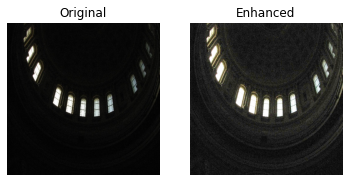

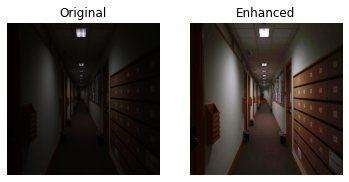

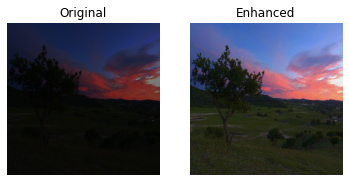

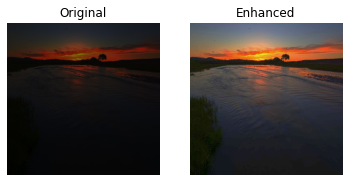

In [9]:
with torch.no_grad():
    for i, sample in enumerate(test_loader):
        img_batch = sample['img'].to(device)
        Astack = model(img_batch)
        enhanced_batch = refine_image(img_batch, Astack)
        
        fig,cache = plot_staff(Astack, img_batch, enhanced_batch)

## A more formal example with number of LE = 8

```bash
# Results shown here is obtained by running the following experiment
# experiment: image size 256x256, kaiming normal, lr=5e-4, 5x exposure loss, n_LE=8, wd=0, 300 epoch
nohup python train.py --device=1 --experiment='256-5xWexp-1' \
    --baseDir=../data/part1-256 --numEpoch=300 >256.log 2>&1 &

# when trainning finish
python eval.py --device=0 --testDir=../data/part1-256/test-toy \
  --ckpt=../train-jobs/ckpt/256-5xWexp-1_best_model.pth 
```

Evaluation results will be stored in `train-jobs/evaluation/256-5xWexp-1`, go check it out!

In [3]:
device = torch.device('cpu')
ckpt = 'train-jobs/ckpt/256-5xWexp-1_best_model.pth'
checkpoint = torch.load(ckpt, map_location=device)
hp=checkpoint['HyperParam']

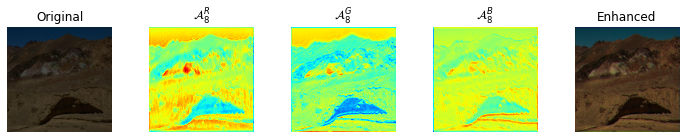

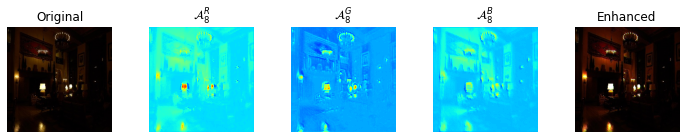

In [29]:
for example in ['353_3.npz', '356_7.npz']:
    res = np.load('train-jobs/evaluation/256-5xWexp-1/' + example)
    img, enhanced, Astack = res['original'], res['enhanced'], res['Astack']
    utils.plot_staff(img, enhanced, Astack, hp['n_LE'], scaler=utils.unnormalize)

#### Check Individual A in each LR iteration for R,G,B channel

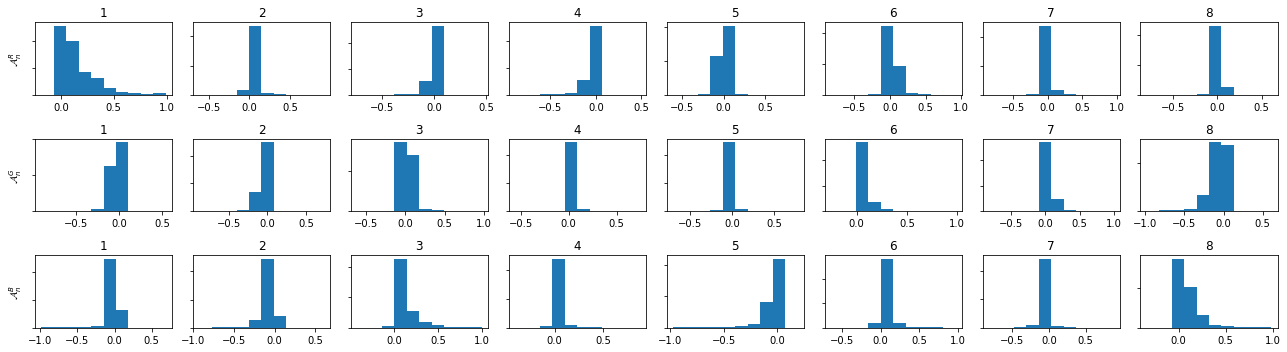

In [19]:
A_Rs, A_Gs, A_Bs = Astack[..., 0::3], Astack[..., 1::3], Astack[..., 2::3]
fig, axes = plt.subplots(3, 8, figsize=(18, 5))
for i in range(8):
    axes[0][i].hist(A_Rs[..., i].ravel())
    axes[1][i].hist(A_Gs[..., i].ravel())
    axes[2][i].hist(A_Bs[..., i].ravel())
    axes[0][i].set_title(i+1)
    axes[1][i].set_title(i+1)
    axes[2][i].set_title(i+1)
for ax in axes.ravel():
    ax.axes.yaxis.set_ticklabels([])
axes[0][0].set_ylabel(r'$\mathcal{A}^{R}_{n}$')
axes[1][0].set_ylabel(r'$\mathcal{A}^{G}_{n}$')
axes[2][0].set_ylabel(r'$\mathcal{A}^{B}_{n}$')
#     axes[0][i].imshow(standardize(A_Rs[..., i]), cmap='rainbow')
#     axes[1][i].imshow(standardize(A_Gs[..., i]), cmap='rainbow')
#     axes[2][i].imshow(standardize(A_Bs[..., i]), cmap='rainbow')
# axes[0]
fig.tight_layout()
# for ax in axes.ravel():
#     ax.axis('off')